In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

working_dir = "/epyc/projects/dschaub/method-projects/spatialnca"
import os

os.chdir(working_dir)
import scanpy as sc
import torch

from types import SimpleNamespace

from spatialnca.data import prepare_data
from spatialnca.model import SpatialNCA
from spatialnca.train import Trainer

from spatialnca.utils import seed_everything, spatial_scatter, plot_pyg, construct_graph
from spatialnca.config import Config

## Load data

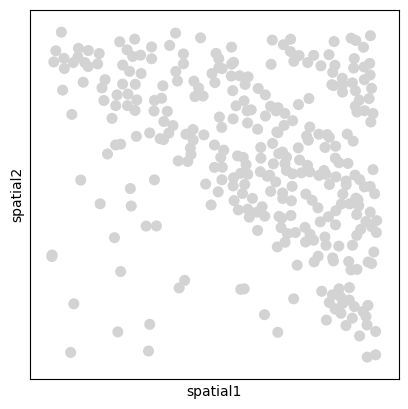

AnnData object with n_obs × n_vars = 318 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color', 'domain', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_identifier'
    uns: 'parcellation_substructure_colors', 'subclass_colors'
    obsm: 'spatial'

In [2]:
path = "data/Zhuang-ABCA-3.003_slice.h5ad"
adata = sc.read_h5ad(path)
sc.pl.spatial(adata, color=None, spot_size=0.01)
adata

In [3]:
# create grid anndata
# adata = generate_grid_adata((10, 10))
# sc.pl.spatial(adata, color=None, spot_size=0.05)

In [4]:
cfg = Config()

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

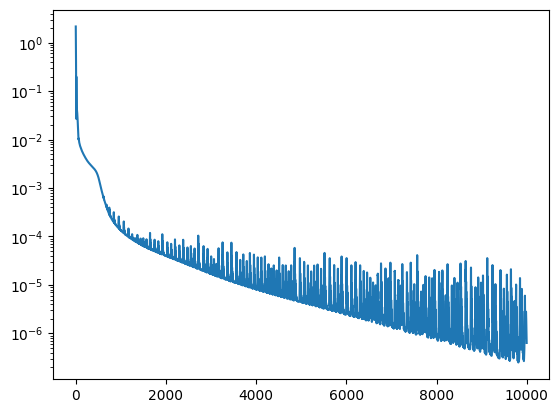

In [5]:
# seed everything
seed_everything(cfg.seed)

data = prepare_data(adata, cfg, construct_edge_index=True)

spnca = SpatialNCA(
    data.num_features,
    cfg,
)

trainer = Trainer(model=spnca, cfg=cfg)

trainer.train(data)

trainer.plot_history()

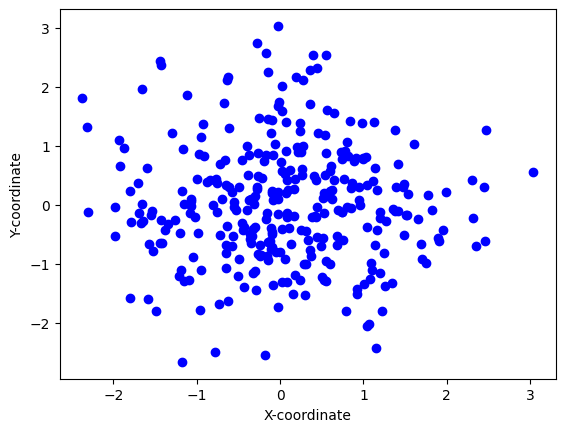

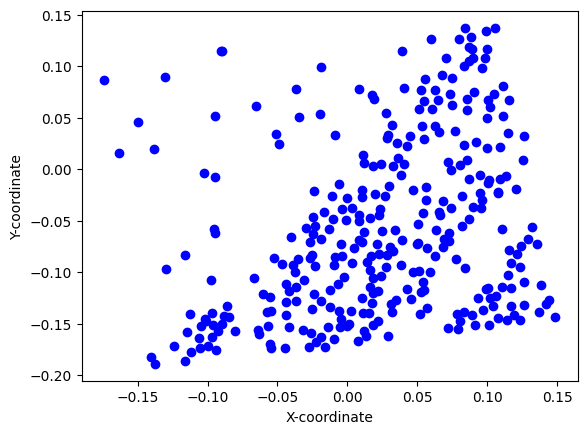

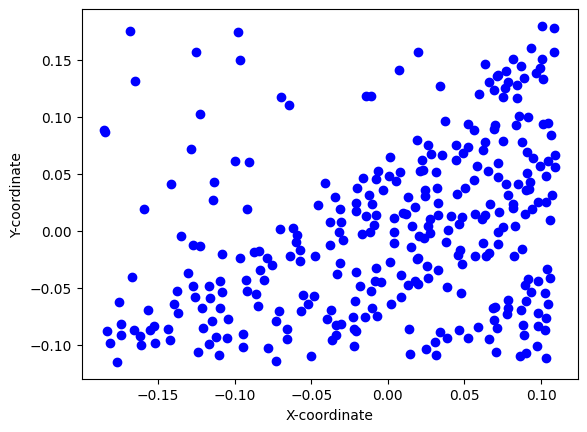

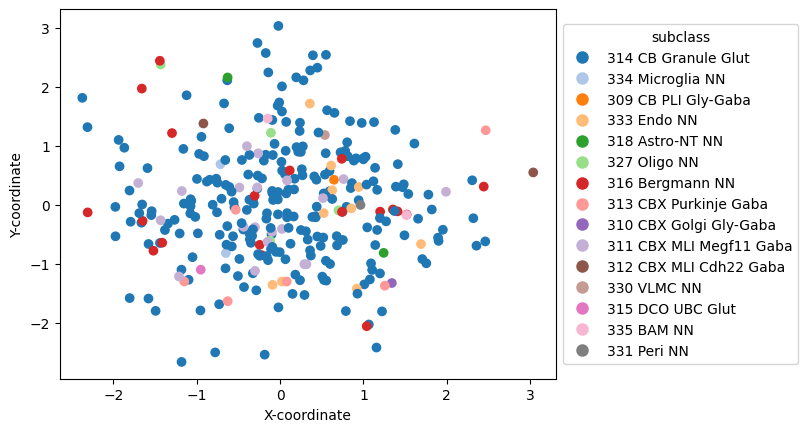

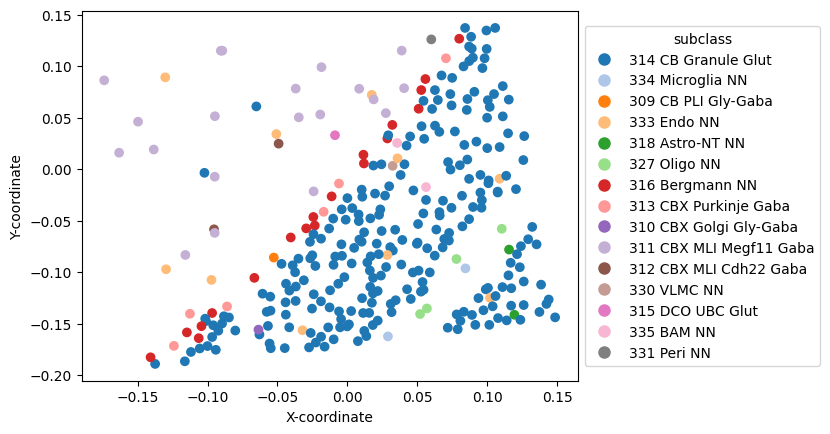

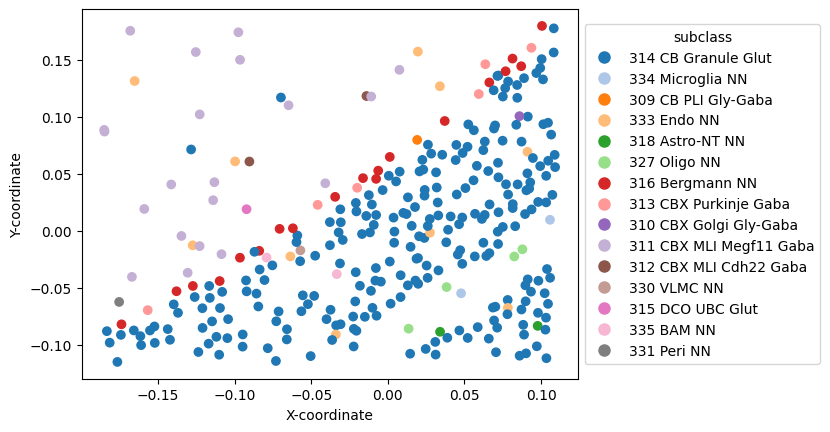

In [6]:
# perform another rollout to check the result
h, pos, edge_index = spnca.rollout(
    x=data.x, pos=data.pos_init, n_steps=cfg.n_steps, edge_index=data.edge_index
)

# convert to anndata for plotting
ad_init = adata.copy()
ad_init.obsm["spatial"] = data.pos_init.cpu().detach().numpy()

ad_final = adata.copy()
ad_final.obsm["spatial"] = pos.cpu().detach().numpy()


spatial_scatter(ad_init, color=None)
spatial_scatter(ad_final, color=None)
spatial_scatter(adata, color=None)


spatial_scatter(ad_init, color="subclass")
spatial_scatter(ad_final, color="subclass")
spatial_scatter(adata, color="subclass")

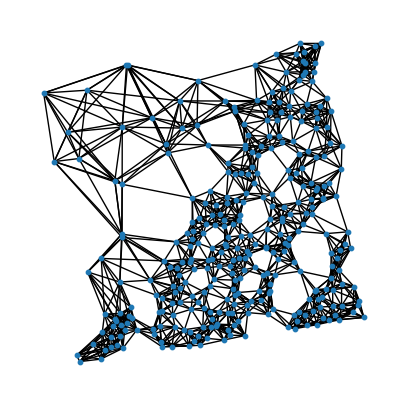

In [7]:
plot_pyg(edge_index, pos=pos)